Epoch 0 | Train Loss: 0.6825 | Val Loss: 0.6700 | Val Acc: 60.00%
Epoch 50 | Train Loss: 0.3948 | Val Loss: 0.3179 | Val Acc: 85.00%
Epoch 100 | Train Loss: 0.3992 | Val Loss: 0.3190 | Val Acc: 86.00%
Epoch 150 | Train Loss: 0.3935 | Val Loss: 0.3178 | Val Acc: 86.00%
Epoch 200 | Train Loss: 0.3943 | Val Loss: 0.3178 | Val Acc: 85.00%
Epoch 250 | Train Loss: 0.3933 | Val Loss: 0.3187 | Val Acc: 84.00%


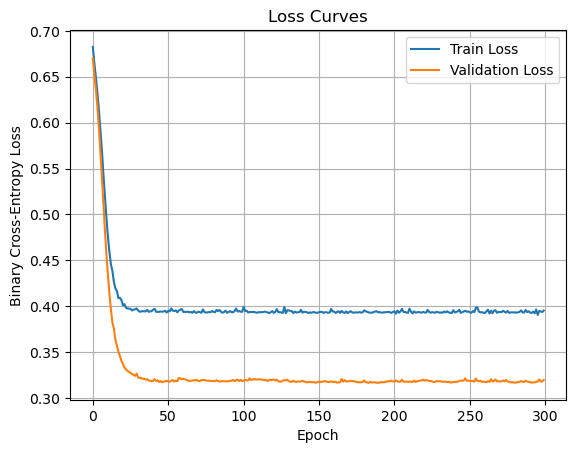


Test Accuracy: 82.00%
Test Loss: 0.4096


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

# Step 1: Generate a more challenging synthetic dataset
# -----------------------------------------------------
n_samples = 500

income = np.random.rand(n_samples, 1)
debt = np.random.rand(n_samples, 1)
credit_score = np.random.rand(n_samples, 1)

X = np.hstack((income, debt, credit_score))

# Add noise and lower weight strength
noise = np.random.normal(0, 0.5, size=(n_samples, 1))
decision_score = 1.2 * income + 1.2 * credit_score - 2.0 * debt + noise

# Convert to probabilities via sigmoid
probability = 1 / (1 + np.exp(-decision_score))

# Binary labels based on noisy threshold
y = (probability > 0.5).astype(np.float32)


# Step 2: Train/Validation/Test Split (60/20/20)
# ----------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=0)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create Datasets and Loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

# Step 3: Define the MLP model
# ----------------------------
class LoanApprovalMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = LoanApprovalMLP()

# Step 4: Loss and optimizer
# --------------------------
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 5: Training loop with validation monitoring
# ------------------------------------------------
epochs = 300
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for xb, yb in train_loader:
        y_pred = model(xb)
        loss = criterion(y_pred, yb)
        epoch_train_loss += loss.item() * xb.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(epoch_train_loss / len(X_train))

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val).item()
        val_losses.append(val_loss)

    if epoch % 50 == 0:
        acc = ((val_pred > 0.5) == y_val).float().mean().item()
        print(f"Epoch {epoch} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.2%}")

# Step 6: Plot train and validation loss curves
# ---------------------------------------------
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# Step 7: Evaluate on Test Set
# ----------------------------
model.eval()
with torch.no_grad():
    test_pred = model(X_test)
    test_acc = ((test_pred > 0.5) == y_test).float().mean().item()
    test_loss = criterion(test_pred, y_test).item()
    print(f"\nTest Accuracy: {test_acc:.2%}")
    print(f"Test Loss: {test_loss:.4f}")


<Figure size 500x400 with 0 Axes>

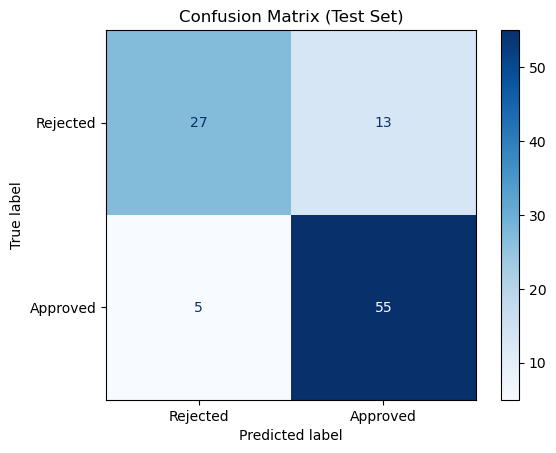


Classification Report:
              precision    recall  f1-score   support

    Rejected       0.84      0.68      0.75        40
    Approved       0.81      0.92      0.86        60

    accuracy                           0.82       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.82      0.82      0.82       100



In [4]:
# Step 9: Confusion Matrix and Classification Report
# ---------------------------------------------------
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    test_preds = model(X_test).numpy().flatten()
    test_labels = y_test.numpy().flatten()
    test_preds_binary = (test_preds > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Rejected", "Approved"])

# Plot confusion matrix
plt.figure(figsize=(5, 4))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.grid(False)
plt.show()

# Precision, Recall, F1
print("\nClassification Report:")
print(classification_report(test_labels, test_preds_binary, target_names=["Rejected", "Approved"]))


### Interpretation of Results

#### **1. Rejected (Class 0)**

| Metric        | Value | Meaning                                                                                                                                            |
| ------------- | ----- | -------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Precision** | 0.84  | When the model predicts "rejected", it is correct 84% of the time. There are some false positives (approved applicants misclassified as rejected). |
| **Recall**    | 0.68  | The model only catches 68% of actual rejected cases. So it **misses many truly rejected applicants**, calling them approved (false negatives).     |
| **F1-score**  | 0.75  | The harmonic mean of precision and recall. A balance between both. Not great due to low recall.                                                    |
| **Support**   | 40    | There were 40 actual "rejected" samples in the test set.                                                                                           |

#### **2. Approved (Class 1)**

| Metric        | Value | Meaning                                                                                                                       |
| ------------- | ----- | ----------------------------------------------------------------------------------------------------------------------------- |
| **Precision** | 0.81  | Of all predictions labeled "approved", 81% were correct. The rest were false positives (rejected people mistakenly approved). |
| **Recall**    | 0.92  | The model **captures most approved cases** — only misses 8% of them.                                                          |
| **F1-score**  | 0.86  | Strong overall balance between precision and recall for this class.                                                           |
| **Support**   | 60    | There were 60 actual "approved" samples.                                                                                      |

---

### Global Metrics

| Metric           | Value              | Meaning                                                                     |
| ---------------- | ------------------ | --------------------------------------------------------------------------- |
| **Accuracy**     | 0.82               | The model correctly classified 82 out of 100 samples.                       |
| **Macro Avg**    | 0.83 / 0.80 / 0.80 | Unweighted mean of metrics across both classes — treats classes equally.    |
| **Weighted Avg** | 0.82 / 0.82 / 0.82 | Averages weighted by support — reflects imbalance in class size (60 vs 40). |

---

### Key Takeaways

* The model is **better at identifying approved applicants** (class 1) than rejected ones.
* **Recall for “Rejected” is low (0.68)**: the model often **fails to identify risky applicants**, which is a problem for a loan officer.
* If the cost of **approving bad loans** is high, we might want to **increase the model’s sensitivity** to rejections, possibly by:

  * Adjusting the decision threshold (e.g., 0.6 instead of 0.5)
  * Using class weighting in loss
  * Collecting more data or features for better discrimination

